In [174]:
# Cell 1
!pip install pennylane pennylane-lightning scikit-learn matplotlib opencv-python

In [175]:
# Cell 2
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pennylane as qml
from pennylane import numpy as pnp

random.seed(42)
np.random.seed(42)
pnp.random.seed(42)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits, shots=None)  # Explicitly set shots

In [176]:
# Cell 3
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# Cell 4
from glob import glob

def collect_images(category_root, image_size=(64, 64)):
    train_good = glob(os.path.join(category_root, 'train', 'good', '*.png'))
    test_good = glob(os.path.join(category_root, 'test', 'good', '*.png'))

    defect_types = [d for d in os.listdir(os.path.join(category_root, 'test')) if d != 'good']
    test_defects = []
    for defect in defect_types:
        defect_paths = glob(os.path.join(category_root, 'test', defect, '*.png'))
        test_defects.extend(defect_paths)

    X = []
    y = []

    # Label 0: Good
    for path in train_good + test_good:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(0)

    # Label 1: Defective
    for path in test_defects:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(1)

    return np.array(X), np.array(y)

In [179]:
# Cell 5 - Check class distribution in training and test sets
print("Training set class distribution:", np.bincount(y_train.astype(int)))
print("Test set class distribution:", np.bincount(y_test.astype(int)))

Training set class distribution: [194 194]
Test set class distribution: [48 19]


In [180]:
# Cell 6 – Unified Data Preparation for Any Object Category
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_object_data(category_path, image_size=(64, 64), n_components=4, test_size=0.2, seed=42):
    """
    Loads images from the given MVTec AD object path, flattens, normalizes, reduces dimension via PCA,
    standardizes features, splits into train/test, and converts to PyTorch tensors.

    Returns:
        X_train_torch, X_test_torch, y_train_torch, y_test_torch, y_test (raw numpy)
    """
    # Step 1: Load and label images
    X, y = collect_images(category_path, image_size=image_size)

    # Step 2: Flatten and normalize image pixels
    X_flat = X.reshape(len(X), -1) / 255.0

    # Step 3: Reduce dimensionality for quantum encoding
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_flat)

    # Step 4: Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=test_size, random_state=seed, stratify=y
    )

    # Step 5: Standardize features
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # Step 6: Convert to PyTorch tensors
    X_train_torch = torch.tensor(X_train_std, dtype=torch.float32)
    X_test_torch = torch.tensor(X_test_std, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)

    return X_train_torch, X_test_torch, y_train_torch, y_test_torch, y_test  # Return y_test for sklearn eval

In [181]:
# Cell 6.5
from sklearn.utils import resample

def balance_classes(X, y):
    X = np.array(X)
    y = np.array(y).flatten()  # Ensure y is 1D

    X_0 = X[y == 0]
    X_1 = X[y == 1]

    if len(X_0) == 0 or len(X_1) == 0:
        return X, y  # nothing to balance

    if len(X_0) > len(X_1):
        X_1_up = resample(X_1, replace=True, n_samples=len(X_0), random_state=42)
        y_1_up = np.ones(len(X_0))
        X_bal = np.vstack([X_0, X_1_up])
        y_bal = np.hstack([np.zeros(len(X_0)), y_1_up])
    else:
        X_0_up = resample(X_0, replace=True, n_samples=len(X_1), random_state=42)
        y_0_up = np.zeros(len(X_1))
        X_bal = np.vstack([X_0_up, X_1])
        y_bal = np.hstack([y_0_up, np.ones(len(X_1))])

    return X_bal, y_bal

In [182]:
# Cell 7 – Load and Prepare Data for Metal Nut
category_path = "/content/drive/MyDrive/Colab Notebooks/metal_nut"
X_train_torch, X_test_torch, y_train_torch, y_test_torch, y_test = prepare_object_data(category_path)

In [183]:
# Cell 8
@qml.qnode(dev)
def quantum_circuit(x, weights):
    x = pnp.array(x, requires_grad=False)
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    for i in range(len(weights)):
        for j in range(n_qubits):
            qml.Rot(*weights[i][j], wires=j)
        for j in range(n_qubits - 1):
            qml.CNOT(wires=[j, j+1])
    return qml.expval(qml.PauliZ(0))

def pad_features(x, target_len=4):
    x = np.array(x)
    if len(x) < target_len:
        return np.pad(x, (0, target_len - len(x)), mode='constant')
    elif len(x) > target_len:
        return x[:target_len]
    return x
# NOTE: Consider PCA or feature selection instead of truncating input.

In [184]:
# Cell 9 (diagnostic cell)
weights = pnp.random.randn(1, n_qubits, 3, requires_grad=True)
sample_outputs = [quantum_circuit(pad_features(x), weights) for x in X_train[:10]]
print("Sample raw outputs:", sample_outputs)

Sample raw outputs: [tensor(0.93717894, requires_grad=True), tensor(-0.58202989, requires_grad=True), tensor(-0.68561706, requires_grad=True), tensor(-0.91132525, requires_grad=True), tensor(-0.60403792, requires_grad=True), tensor(0.44709576, requires_grad=True), tensor(-0.39819518, requires_grad=True), tensor(0.13017063, requires_grad=True), tensor(0.93717894, requires_grad=True), tensor(-0.93544522, requires_grad=True)]


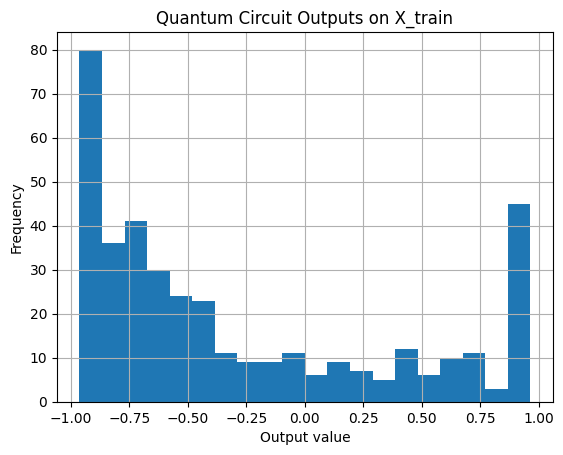

In [185]:
# Cell 10
outputs = [quantum_circuit(pad_features(x), weights) for x in X_train]
outputs = [float(o) for o in outputs]

plt.hist(outputs, bins=20)
plt.title("Quantum Circuit Outputs on X_train")
plt.xlabel("Output value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [186]:
# Cell 11
import time
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane.qnn import TorchLayer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Define shared training function
def train_model(model, X, y, epochs=15, lr=0.1, name="QuantumModel"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    start = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        acc = ((y_pred > 0.5).float() == y).float().mean()
        print(f"[{name}] Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {acc.item():.3f}")

    print(f"[{name}] Training time: {time.time() - start:.2f} seconds")

# Standardize again
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_torch = torch.tensor(X_train_std, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_std, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# QNode
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits, 3)}
dev = qml.device("default.qubit", wires=n_qubits, shots=None)  # Explicitly set shots

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

qlayer = TorchLayer(qnode, weight_shapes)

class HybridClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = qlayer
        self.fc = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.quantum(x)
        return self.fc(x.unsqueeze(1))

# Train VQC-1
model = HybridClassifier()
train_model(model, X_train_torch, y_train_torch, name="VQC-1")

[VQC-1] Epoch 1: Loss = 0.7184, Accuracy = 0.500
[VQC-1] Epoch 2: Loss = 0.6989, Accuracy = 0.500
[VQC-1] Epoch 3: Loss = 0.6818, Accuracy = 0.505
[VQC-1] Epoch 4: Loss = 0.6674, Accuracy = 0.588
[VQC-1] Epoch 5: Loss = 0.6544, Accuracy = 0.621
[VQC-1] Epoch 6: Loss = 0.6442, Accuracy = 0.647
[VQC-1] Epoch 7: Loss = 0.6359, Accuracy = 0.673
[VQC-1] Epoch 8: Loss = 0.6288, Accuracy = 0.706
[VQC-1] Epoch 9: Loss = 0.6246, Accuracy = 0.693
[VQC-1] Epoch 10: Loss = 0.6194, Accuracy = 0.701
[VQC-1] Epoch 11: Loss = 0.6150, Accuracy = 0.729
[VQC-1] Epoch 12: Loss = 0.6102, Accuracy = 0.714
[VQC-1] Epoch 13: Loss = 0.6041, Accuracy = 0.719
[VQC-1] Epoch 14: Loss = 0.5995, Accuracy = 0.714
[VQC-1] Epoch 15: Loss = 0.5942, Accuracy = 0.719
[VQC-1] Training time: 0.88 seconds


In [201]:
# Cell 12 – Loop over all objects using VQC-1

object_names = ["metal_nut", "transistor", "cable", "grid"]
base_path = "/content/drive/MyDrive/Colab Notebooks"

results = []
all_preds = {}  # Store predictions per object
all_truths = {}

for obj in object_names:
    print(f"\n================== {obj.upper()} ==================")
    path = os.path.join(base_path, obj)

    # Load data for the current object
    X_train_obj, X_test_obj, y_train_obj, y_test_torch_obj, y_test_obj = prepare_object_data(path)

    # Balance the training set for this object
    X_train_obj, y_train_obj = balance_classes(X_train_obj, y_train_obj)
    X_train_torch = torch.tensor(X_train_obj, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_obj, dtype=torch.float32).unsqueeze(1)

    # Train model
    model = HybridClassifier()
    train_model(model, X_train_torch, y_train_torch, name=f"VQC-1 ({obj})")

    # Evaluate on test set
    X_test_torch = X_test_obj.clone().detach().float() if isinstance(X_test_obj, torch.Tensor) else torch.tensor(X_test_obj, dtype=torch.float32)
    with torch.no_grad():
        y_pred_test = model(X_test_torch).squeeze().detach().numpy()
        threshold = 0.5
        y_pred_label = (y_pred_test > threshold).astype(int)

    print(f"\n[{obj}] Test Set Evaluation:")
    report = classification_report(y_test_obj, y_pred_label, output_dict=True)
    print(classification_report(y_test_obj, y_pred_label))

    # Store predictions and true labels
    all_preds[obj] = y_pred_test
    all_truths[obj] = y_test_obj

    results.append({
        "object": obj,
        "accuracy": report["accuracy"],
        "f1_defect": report["1"]["f1-score"],
        "recall_defect": report["1"]["recall"],
        "precision_defect": report["1"]["precision"]
    })

# Diagnostic printout: label distributions and sample outputs per object
for obj in object_names:
    y_pred_raw = all_preds[obj]
    y_true = all_truths[obj]

    print(f"\n=== {obj.upper()} ===")
    print("Predicted label distribution:", np.bincount((y_pred_raw > 0.3).astype(int)))
    print("True label distribution:", np.bincount(y_true))
    print("Sample raw outputs:", y_pred_raw[:5])


================== METAL_NUT ==================
[VQC-1 (metal_nut)] Epoch 1: Loss = 0.7138, Accuracy = 0.500
[VQC-1 (metal_nut)] Epoch 2: Loss = 0.6748, Accuracy = 0.536
[VQC-1 (metal_nut)] Epoch 3: Loss = 0.6559, Accuracy = 0.606
[VQC-1 (metal_nut)] Epoch 4: Loss = 0.6403, Accuracy = 0.660
[VQC-1 (metal_nut)] Epoch 5: Loss = 0.6245, Accuracy = 0.711
[VQC-1 (metal_nut)] Epoch 6: Loss = 0.6169, Accuracy = 0.724
[VQC-1 (metal_nut)] Epoch 7: Loss = 0.6105, Accuracy = 0.719
[VQC-1 (metal_nut)] Epoch 8: Loss = 0.6015, Accuracy = 0.709
[VQC-1 (metal_nut)] Epoch 9: Loss = 0.5955, Accuracy = 0.688
[VQC-1 (metal_nut)] Epoch 10: Loss = 0.5883, Accuracy = 0.729
[VQC-1 (metal_nut)] Epoch 11: Loss = 0.5833, Accuracy = 0.727
[VQC-1 (metal_nut)] Epoch 12: Loss = 0.5775, Accuracy = 0.732
[VQC-1 (metal_nut)] Epoch 13: Loss = 0.5727, Accuracy = 0.680
[VQC-1 (metal_nut)] Epoch 14: Loss = 0.5694, Accuracy = 0.675
[VQC-1 (metal_nut)] Epoch 15: Loss = 0.5639, Accuracy = 0.701
[VQC-1 (metal_nut)] Training t

In [188]:
# Cell 13 – Summary of all object results

import pandas as pd

summary_df = pd.DataFrame(results)
summary_df = summary_df[["object", "accuracy", "precision_defect", "recall_defect", "f1_defect"]]
summary_df = summary_df.sort_values(by="object").reset_index(drop=True)

# Round for clarity
summary_df[["accuracy", "precision_defect", "recall_defect", "f1_defect"]] = summary_df[
    ["accuracy", "precision_defect", "recall_defect", "f1_defect"]
].round(3)

# Display summary
print("Summary of VQC-1 Performance by Object:")
display(summary_df)

# Save to CSV
summary_df.to_csv("vqc1_summary_results.csv", index=False)


Summary of VQC-1 Performance by Object:


,object,accuracy,precision_defect,recall_defect,f1_defect
0,cable,0.387,0.274,0.944,0.425
1,grid,0.449,0.171,0.636,0.269
2,metal_nut,0.701,0.478,0.579,0.524
3,transistor,0.714,0.308,1.000,0.471


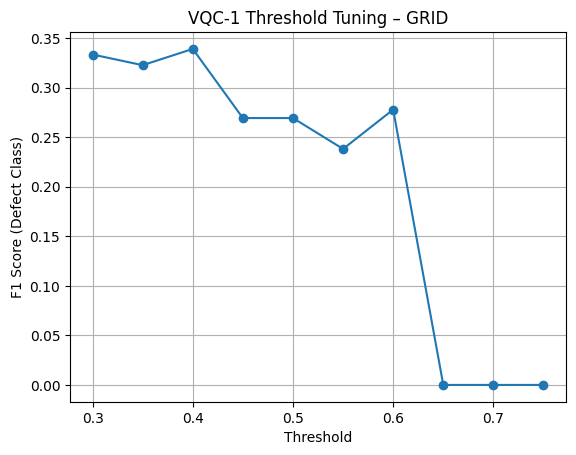

Best threshold for defect detection (grid): 0.40 with F1 = 0.339


In [189]:
# Cell 14 – Threshold Sweep for VQC-1 (Defect Detection Performance)
from sklearn.metrics import precision_recall_fscore_support

# Set object to evaluate (e.g., "grid", "transistor", etc.)
obj = "grid"
y_pred_test = all_preds[obj]
y_test = all_truths[obj]

# Sanity check
assert len(y_pred_test) == len(y_test), f"Mismatch: y_pred_test={len(y_pred_test)}, y_test={len(y_test)}"

thresholds = np.arange(0.3, 0.8, 0.05)
f1_scores_defect = []

for t in thresholds:
    preds = (y_pred_test > t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test, preds, zero_division=0)
    f1_scores_defect.append(f1[1])

plt.plot(thresholds, f1_scores_defect, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Defect Class)")
plt.title(f"VQC-1 Threshold Tuning – {obj.upper()}")
plt.grid(True)
plt.show()

best_t = thresholds[np.argmax(f1_scores_defect)]
print(f"Best threshold for defect detection ({obj}): {best_t:.2f} with F1 = {max(f1_scores_defect):.3f}")


In [190]:
# Cell 15 – VQC-1 Evaluation Using Best Threshold (0.50)

# Apply best threshold found from tuning
y_pred_label_best = (y_pred_test > 0.50).astype(int)

# Print updated report
from sklearn.metrics import classification_report
print("VQC-1 Final Evaluation (Threshold = 0.50)")
print(classification_report(y_test, y_pred_label_best, target_names=["good", "defect"]))

VQC-1 Final Evaluation (Threshold = 0.50)
              precision    recall  f1-score   support

        good       0.86      0.41      0.56        58
      defect       0.17      0.64      0.27        11

    accuracy                           0.45        69
   macro avg       0.51      0.53      0.41        69
weighted avg       0.75      0.45      0.51        69



In [191]:
# Cell 16 – Evaluation for specific object
from sklearn.metrics import classification_report

obj = "metal_nut"  # or "grid", "cable", "transistor"
y_pred_test = all_preds[obj]
y_test = all_truths[obj]

print(f"[{obj.upper()}] Evaluation at default threshold 0.5:")
print(classification_report(y_test, (y_pred_test > 0.5).astype(int)))

[METAL_NUT] Evaluation at default threshold 0.5:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        48
           1       0.48      0.58      0.52        19

    accuracy                           0.70        67
   macro avg       0.65      0.66      0.65        67
weighted avg       0.72      0.70      0.71        67



In [192]:
# Cell 17
import numpy as np
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(48), np.int64(1): np.int64(19)}


In [203]:
# Cell 18
from sklearn.utils import resample

# Convert to numpy for resampling
X_np = X_train
y_np = y_train

# Split into class 0 and class 1
X_pos = X_np[y_np == 1]
X_neg = X_np[y_np == 0]

# Oversample minority class
X_pos_upsampled, y_pos_upsampled = resample(
    X_pos, np.ones(len(X_pos)),
    replace=True,
    n_samples=len(X_neg),
    random_state=42
)

# Combine and shuffle
X_balanced = np.vstack([X_neg, X_pos_upsampled])
y_balanced = np.hstack([np.zeros(len(X_neg)), y_pos_upsampled])
perm = np.random.permutation(len(y_balanced))

# Standardize again
X_balanced_std = scaler.fit_transform(X_balanced)

# Convert to tensors
X_train_torch = torch.tensor(X_balanced_std[perm], dtype=torch.float32)
y_train_torch = torch.tensor(y_balanced[perm], dtype=torch.float32).unsqueeze(1)

# Retrain
model = HybridClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

for epoch in range(15):
    optimizer.zero_grad()
    y_pred = model(X_train_torch)
    loss = loss_fn(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    acc = ((y_pred > 0.5).float() == y_train_torch).float().mean()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {acc.item():.3f}")

# Evaluate on test set
X_test_torch = torch.tensor(X_test, dtype=torch.float32)  # use the correct matching test set
with torch.no_grad():
    y_pred_test = model(X_test_torch).squeeze().numpy()
    y_pred_label = (y_pred_test > 0.5).astype(int)

print("\nTest set evaluation:")
print(classification_report(y_test.astype(int), y_pred_label))

Epoch 1: Loss = 0.7972, Accuracy = 0.500
Epoch 2: Loss = 0.7622, Accuracy = 0.500
Epoch 3: Loss = 0.7270, Accuracy = 0.500
Epoch 4: Loss = 0.6966, Accuracy = 0.500
Epoch 5: Loss = 0.6783, Accuracy = 0.508
Epoch 6: Loss = 0.6659, Accuracy = 0.624
Epoch 7: Loss = 0.6528, Accuracy = 0.657
Epoch 8: Loss = 0.6387, Accuracy = 0.701
Epoch 9: Loss = 0.6269, Accuracy = 0.675
Epoch 10: Loss = 0.6188, Accuracy = 0.680
Epoch 11: Loss = 0.6118, Accuracy = 0.716
Epoch 12: Loss = 0.6040, Accuracy = 0.722
Epoch 13: Loss = 0.5961, Accuracy = 0.698
Epoch 14: Loss = 0.5891, Accuracy = 0.691
Epoch 15: Loss = 0.5838, Accuracy = 0.711

Test set evaluation:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66        48
           1       0.25      0.32      0.28        19

    accuracy                           0.54        67
   macro avg       0.47      0.47      0.47        67
weighted avg       0.57      0.54      0.55        67



SVM training time: 0.06 seconds
SVM Performance:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        48
           1       0.42      0.58      0.49        19

    accuracy                           0.66        67
   macro avg       0.61      0.63      0.62        67
weighted avg       0.70      0.66      0.67        67



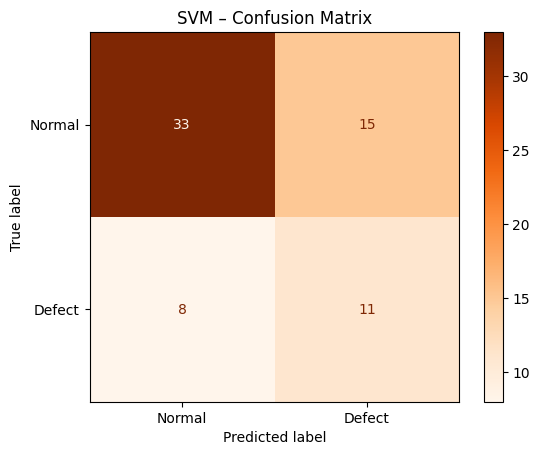

In [195]:
# Cell 19 – Classical Baseline (SVM)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Train classical SVM on original (imbalanced) dataset
clf = SVC(kernel='rbf', probability=True, random_state=42)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
print(f"SVM training time: {end_time - start_time:.2f} seconds")

# Evaluate
y_pred_svm = clf.predict(X_test)
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Defect"])
disp.plot(cmap="Oranges")
plt.title("SVM – Confusion Matrix")
plt.show()

In [196]:
# Cell 20 – Classical SVM with Class Balancing
from sklearn.svm import SVC

# Train balanced SVM using already scaled inputs
svm_balanced = SVC(kernel='linear', class_weight='balanced')
svm_balanced.fit(X_train, y_train)

y_pred_balanced = svm_balanced.predict(X_test)

print("[SVM Balanced] Test set evaluation:")
print(classification_report(y_test, y_pred_balanced))

[SVM Balanced] Test set evaluation:
              precision    recall  f1-score   support

           0       0.72      0.27      0.39        48
           1       0.29      0.74      0.41        19

    accuracy                           0.40        67
   macro avg       0.50      0.50      0.40        67
weighted avg       0.60      0.40      0.40        67



In [197]:
# Cell 21
from pennylane.qnn import TorchLayer

# Define second circuit with fewer parameters
@qml.qnode(dev, interface="torch")
def qnode_custom(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

# Setup new TorchLayer (only 4 RY angles)
custom_weight_shapes = {"weights": (n_qubits,)}
qlayer_custom = TorchLayer(qnode_custom, custom_weight_shapes)

# Define matching model architecture
class CustomQuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = qlayer_custom
        self.fc = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.quantum(x)
        return self.fc(x.unsqueeze(1))

In [198]:
# Cell 22
print("\nTraining Custom Circuit (VQC-2)...")

model_custom = CustomQuantumClassifier()
train_model(model_custom, X_train_torch, y_train_torch, name="VQC-2")

# Evaluate
with torch.no_grad():
    y_pred_test_custom = model_custom(X_test_torch).squeeze().numpy()
    y_pred_label_custom = (y_pred_test_custom > 0.5).astype(int)

print("\n[Custom Circuit] Test set evaluation:")
print(classification_report(y_test, y_pred_label_custom))


Training Custom Circuit (VQC-2)...
[VQC-2] Epoch 1: Loss = 0.7548, Accuracy = 0.500
[VQC-2] Epoch 2: Loss = 0.7279, Accuracy = 0.500
[VQC-2] Epoch 3: Loss = 0.7070, Accuracy = 0.515
[VQC-2] Epoch 4: Loss = 0.6923, Accuracy = 0.549
[VQC-2] Epoch 5: Loss = 0.6840, Accuracy = 0.603
[VQC-2] Epoch 6: Loss = 0.6810, Accuracy = 0.572
[VQC-2] Epoch 7: Loss = 0.6819, Accuracy = 0.546
[VQC-2] Epoch 8: Loss = 0.6847, Accuracy = 0.495
[VQC-2] Epoch 9: Loss = 0.6875, Accuracy = 0.500
[VQC-2] Epoch 10: Loss = 0.6892, Accuracy = 0.500
[VQC-2] Epoch 11: Loss = 0.6893, Accuracy = 0.500
[VQC-2] Epoch 12: Loss = 0.6879, Accuracy = 0.500
[VQC-2] Epoch 13: Loss = 0.6853, Accuracy = 0.500
[VQC-2] Epoch 14: Loss = 0.6820, Accuracy = 0.472
[VQC-2] Epoch 15: Loss = 0.6786, Accuracy = 0.518
[VQC-2] Training time: 0.31 seconds

[Custom Circuit] Test set evaluation:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        48
           1       0.25      0.11      

In [199]:
# Cell 23 – Final Evaluation (threshold = 0.6)
alt_threshold = 0.6
y_pred_label_custom_alt = (y_pred_test_custom > alt_threshold).astype(int)

print(f"\n[Custom Circuit] Evaluation with threshold > {alt_threshold}:")
print(classification_report(y_test, y_pred_label_custom_alt))


[Custom Circuit] Evaluation with threshold > 0.6:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83        48
           1       0.00      0.00      0.00        19

    accuracy                           0.72        67
   macro avg       0.36      0.50      0.42        67
weighted avg       0.51      0.72      0.60        67



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


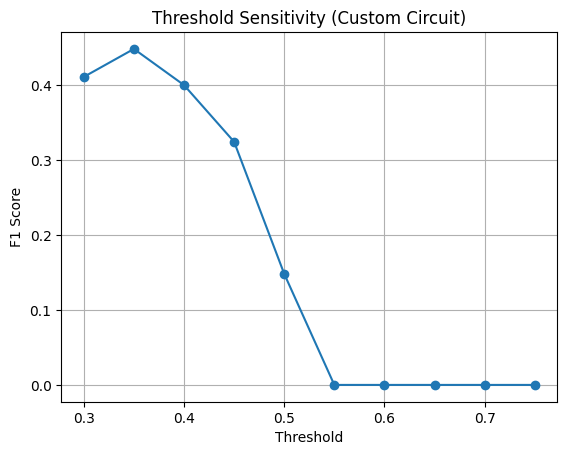

In [200]:
# Cell 24 – Threshold Sensitivity Plot
from sklearn.metrics import f1_score

thresholds = np.arange(0.3, 0.8, 0.05)
f1_scores = [
    f1_score(y_test, (y_pred_test_custom > t).astype(int))
    for t in thresholds
]

plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Sensitivity (Custom Circuit)")
plt.grid(True)
plt.show()